# RDN applied to social influence echo chamber model

> CITATION NEEDED

#### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import datetime
import itertools
import vaex
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable
from pathlib import Path
from tqdm.notebook import tqdm


from opdynamics.metrics.opinions import sample_means
from opdynamics.utils.constants import *
from opdynamics.utils.decorators import optional_fig_ax, hash_repeat
from opdynamics.utils.plot_utils import colorbar_inset, colorline

from social_influence_echo_chamber_model.echo_chamber_dynamics import (
    EchoChamberDynamics,
)
from social_influence_echo_chamber_model.analysis import screen_diversity, num_opinion_peaks

np.random.seed(1337)
sns.set_theme(
    context="notebook",
    style="ticks",
    rc={
        "pdf.fonttype": 42,  # embed font in output
        "svg.fonttype": "none",  # embed font in output
        "figure.facecolor": "white",
        "figure.dpi": 200,
        "axes.facecolor": "None",
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    },
)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger("nb-social")


In [3]:
@optional_fig_ax
def plot_agents(
    df,
    color_code=True,
    subsample: int = 1,
    ax: plt.Axes = None,
    fig: plt.Figure = None,
    **kwargs
):
    cmap = kwargs.pop("cmap", OPINIONS_CMAP)
    vmin = kwargs.pop("vmin", np.min(df.values))
    vmax = kwargs.pop("vmax", np.max(df.values))
    lw = kwargs.pop("lw", 0.1)

    try:
        sm = ScalarMappable(norm=TwoSlopeNorm(0, vmin, vmax), cmap=cmap)
    except ValueError:
        sm = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap)
    import pandas as pd

    df_opinions: pd.DataFrame = df.iloc[::subsample]

    if color_code == "line" or color_code == "lines":
        # using the colorline method allows colors to be dependent on a value, in this case, opinion,
        # but takes much longer to display
        for agent_idx, agent_opinions in df_opinions.iteritems():
            c = sm.to_rgba(agent_opinions.values)
            colorline(
                agent_opinions.index,
                agent_opinions.values,
                c,
                lw=lw,
                ax=ax,
                **kwargs,
            )
    elif color_code:
        for agent_idx, agent_opinions in df_opinions.iteritems():
            c = sm.to_rgba(agent_opinions.values)
            s = kwargs.pop("s", 0.1)
            ax.scatter(
                agent_opinions.index,
                agent_opinions.values,
                c=c,
                s=s,
                lw=0,
                **kwargs,
            )
    else:
        ls = kwargs.pop("ls", "-")
        mec = kwargs.pop("mec", "None")
        cmap_colors = sns.color_palette(cmap, n_colors=df_opinions.shape[0])
        for agent_idx, agent_opinions in df_opinions.iteritems():
            ax.plot(
                df_opinions,
                c=cmap_colors[int(agent_idx)],
                ls=ls,
                mec=mec,
                lw=lw,
                **kwargs,
            )

    ax.set_xlim(0, df_opinions.index[-1])
    ax.set_xlabel(TIME_SYMBOL)
    ax.set_ylabel(OPINION_AGENT_TIME)
    ax.set_ylim(vmin, vmax)

    return fig, ax


In [4]:
from social_influence_echo_chamber_model.nudge import full_nudge, sample_nudge

def load_csvxz(data_root_dir, file_name) -> pd.DataFrame:
    return pd.read_csv(f"{data_root_dir}/data/{file_name}.csv.xz", index_col=0)

def load_opinions(data_root_dir):
    return load_csvxz(data_root_dir,"opinions")

def load_screen_diversity(data_root_dir):
    return load_csvxz(data_root_dir,"screen_diversity")

def is_unstable(opinions, subsample=100, thresh=1.0):
    """Check if the numerical simulation increases (on average) by more than a threshold"""
    return np.any(opinions.iloc[::subsample].abs().mean(axis=1).diff()>thresh)

def run_simulation(
    n_agents=100,
    n_links=400,
    sns_seed=1,
    l=10,  # screen size
    t_max=10000,  # max steps
    epsilon=0.5,  # bounded confidence parameter
    mu=0.5,  # social influence strength
    p=0.5,  # repost rate
    q=0.5,  # rewiring rate
    following_methods=["Random"],  # , "Respost", "Recommendation"
    nudge_strength=0,
    nudge_sample_size=5,
    nudge_method=full_nudge,
    nudge_delay=0,
    plot=True,
    save_plot=True,
):
    assert nudge_delay < t_max, "nudge_delay must be less than t_max"
    nudge = (nudge_strength, nudge_sample_size, nudge_method)

    name_str = (
        f"{n_agents=}\n{n_links=}\n{l=}\n{t_max=}\n{mu=}\n{p=}\n{q=}\n{epsilon=}"
        f"\n{following_methods=}\n{sns_seed=}\n"
    )
    if nudge[0] > 0:
        name_str += f"{nudge_strength=}\n{nudge_sample_size=}\nnudge_method={nudge_method.__name__})\n"
    if nudge_delay > 0:
        name_str += f"{nudge_delay=}\n"

    hash_value = hash_repeat(name_str)
    now_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    data_root_dir = Path(f"data/data_{hash_value}")

    if not data_root_dir.exists():
        print(f"Creating directory {data_root_dir}")
        (data_root_dir / "data").mkdir(parents=True)
        (data_root_dir / "network_data").mkdir()

        with open(data_root_dir / "name.txt", "w") as f:
            f.write(name_str)
        s = datetime.datetime.now()

        fileh = logging.FileHandler(f"{data_root_dir}/log.txt", "w")
        formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        )
        fileh.setFormatter(formatter)
        for hdlr in logger.handlers[:]:  # remove old file handler
            if isinstance(hdlr, logging.FileHandler):
                logger.removeHandler(hdlr)
        logger.addHandler(fileh)  # set the new handler

        logger.info(f"Starting simulation.")
        d = EchoChamberDynamics(
            n_agents, n_links, epsilon, sns_seed, l, str(data_root_dir)
        )
        if nudge_delay:
            logger.info(f"nudge=0 for {nudge_delay} steps.")
            d.evolve(nudge_delay, mu, p, q, following_methods, nudge=0)
            remainder_steps = t_max - nudge_delay
            logger.info(f"{nudge=} for {remainder_steps} steps.")
            d.evolve(remainder_steps, mu, p, q, following_methods, nudge=nudge)
        else:
            d.evolve(t_max, mu, p, q, following_methods, nudge=nudge)

        e = datetime.datetime.now()
        logger.info(f"Simulation finished. Took {e - s}")
        logger.removeHandler(fileh)

    if plot:
        opinions = load_opinions(data_root_dir)
        screen_diversity = load_screen_diversity(data_root_dir)
        
        fig, axes = plt.subplots(nrows=2, sharex=True)
        plot_agents(opinions, color_code="line", subsample=10, fig=fig, ax=axes[0])
        plot_agents(screen_diversity, fig=fig, ax=axes[1], cmap="Greens_r")

        for ax in axes:
            ax.axvline(nudge_delay, color="k", alpha=0.3, ls="--")

        axes[0].set_clip_on(False)
        axes[0].set_xlabel("")
        axes[0].annotate(
            "",
            xy=(nudge_delay, opinions.values.max()),
            xytext=(0, 20),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="-|>", color="k"),
            clip_on=False,
            ha="center",
            va="top",
        )
        fig.suptitle(f"{nudge_strength=}, {nudge_sample_size=}")
        if save_plot:
            fig.savefig(f"{data_root_dir}/opinions.jpg")

    return data_root_dir


In [6]:
t_max = 50000
nudge_delay = 5000
nudge_strength = 0.2
nudge_sample_size = 5
nudge_method = full_nudge

seeds = [1, 1337, 1001, 926814, 170249, 987654321, 147658, 1235689, 1325896, 9671235]

all_dirs = []

for seed, D, n in tqdm(
    list(itertools.product(seeds, [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0], [1, 5, 10, 15]))
):
    data_root_dir = run_simulation(
        t_max=t_max,
        sns_seed=seed,
        nudge_strength=D,
        nudge_sample_size=n,
        nudge_method=full_nudge,
        nudge_delay=nudge_delay,
        plot=True,
        save_plot=True,
    )
    all_dirs.append(data_root_dir)


  0%|          | 0/320 [00:00<?, ?it/s]

2022-02-02 12:42:40,685 - nb-social - INFO - Starting simulation.
2022-02-02 12:42:40,689 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_81729025398472026049995600662556875980286791793407811278135893956815808997616


2022-02-02 12:42:52,953 - nb-social - INFO - nudge=(0.01, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 12:50:16,160 - nb-social - INFO - Simulation finished. Took 0:07:35.475630
2022-02-02 12:50:16,197 - nb-social - INFO - Starting simulation.
2022-02-02 12:50:16,200 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_44396398240242353020739314445369583534972578391581238146315555719129434727536


2022-02-02 12:50:28,561 - nb-social - INFO - nudge=(0.05, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 12:57:49,157 - nb-social - INFO - Simulation finished. Took 0:07:32.960471
2022-02-02 12:57:49,192 - nb-social - INFO - Starting simulation.
2022-02-02 12:57:49,195 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_7929496900274725393534303403025690675781188577872336271256309210421063578829


2022-02-02 12:58:02,072 - nb-social - INFO - nudge=(0.1, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 13:45:20,711 - nb-social - INFO - Simulation finished. Took 0:47:31.518163
2022-02-02 13:45:20,761 - nb-social - INFO - Starting simulation.
2022-02-02 13:45:20,766 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_5754430741797920325944051088919209269387337333396095069250780114728446841742


2022-02-02 13:53:46,812 - nb-social - INFO - nudge=(0.15, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:15:16,097 - nb-social - INFO - Simulation finished. Took 0:29:55.336269
2022-02-02 14:15:16,134 - nb-social - INFO - Starting simulation.
2022-02-02 14:15:16,138 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_110381918260638213715218925862605095842338125744796631535880930056334043384650


2022-02-02 14:15:27,810 - nb-social - INFO - nudge=(0.2, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:22:43,310 - nb-social - INFO - Simulation finished. Took 0:07:27.176586
2022-02-02 14:22:43,347 - nb-social - INFO - Starting simulation.
2022-02-02 14:22:43,350 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_45223962570958501655597338496949583611617338343853710844742404231772452125451


2022-02-02 14:22:53,515 - nb-social - INFO - nudge=(0.25, 1, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:31:34,338 - nb-social - INFO - Simulation finished. Took 0:08:50.991239
2022-02-02 14:31:34,367 - nb-social - INFO - Starting simulation.
2022-02-02 14:31:34,370 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_94655298486055078199017218971186434515220713457098057575550189324164103089199


2022-02-02 14:31:46,701 - nb-social - INFO - nudge=(0.25, 5, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:39:13,469 - nb-social - INFO - Simulation finished. Took 0:07:39.102045
2022-02-02 14:39:13,505 - nb-social - INFO - Starting simulation.
2022-02-02 14:39:13,508 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_7541476404640488594544818987151072773160595031921117123895529122612836852163


2022-02-02 14:39:26,108 - nb-social - INFO - nudge=(0.25, 10, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:45:52,248 - nb-social - INFO - Simulation finished. Took 0:06:38.743651
2022-02-02 14:45:52,281 - nb-social - INFO - Starting simulation.
2022-02-02 14:45:52,284 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_26997945987701149897209770271489205323890064202389610674015577792862499752050


2022-02-02 14:46:04,483 - nb-social - INFO - nudge=(0.25, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:49:11,254 - nb-social - INFO - Simulation finished. Took 0:03:18.972815
2022-02-02 14:49:11,277 - nb-social - INFO - Starting simulation.
2022-02-02 14:49:11,279 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_63225337054243564839726515266669244152617173573348996938332678820537492357684


2022-02-02 14:49:23,475 - nb-social - INFO - nudge=(0.3, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 14:56:57,623 - nb-social - INFO - Simulation finished. Took 0:07:46.346734
2022-02-02 14:56:57,663 - nb-social - INFO - Starting simulation.
2022-02-02 14:56:57,666 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_80409924151243173857440415458816782980048012426659598796781743478575659505305


2022-02-02 14:57:10,432 - nb-social - INFO - nudge=(0.01, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:04:55,401 - nb-social - INFO - Simulation finished. Took 0:07:57.738901
2022-02-02 15:04:55,435 - nb-social - INFO - Starting simulation.
2022-02-02 15:04:55,438 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_79851173521042466603143461425196761042710584876292567377755426456615999881433


2022-02-02 15:05:07,783 - nb-social - INFO - nudge=(0.05, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:12:32,796 - nb-social - INFO - Simulation finished. Took 0:07:37.361070
2022-02-02 15:12:32,832 - nb-social - INFO - Starting simulation.
2022-02-02 15:12:32,835 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_1522269322980953003112303142640167727731111019650818913331849071890029640300


2022-02-02 15:12:45,926 - nb-social - INFO - nudge=(0.1, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:20:13,881 - nb-social - INFO - Simulation finished. Took 0:07:41.049230
2022-02-02 15:20:13,919 - nb-social - INFO - Starting simulation.
2022-02-02 15:20:13,922 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_65639638292815619270560827247137698397935291661140691718883999611888131292495


2022-02-02 15:20:26,130 - nb-social - INFO - nudge=(0.15, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:28:03,234 - nb-social - INFO - Simulation finished. Took 0:07:49.314597
2022-02-02 15:28:03,271 - nb-social - INFO - Starting simulation.
2022-02-02 15:28:03,274 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_115292429961598834738046916713977361995974772221559998055103623181118665010512


2022-02-02 15:28:16,121 - nb-social - INFO - nudge=(0.2, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:31:42,234 - nb-social - INFO - Simulation finished. Took 0:03:38.963302
2022-02-02 15:31:42,263 - nb-social - INFO - Starting simulation.
2022-02-02 15:31:42,267 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_32675480519232800229395689798550178182569455203737189911626140959409114328944


2022-02-02 15:31:56,596 - nb-social - INFO - nudge=(0.25, 1, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:39:41,323 - nb-social - INFO - Simulation finished. Took 0:07:59.060205
2022-02-02 15:39:41,373 - nb-social - INFO - Starting simulation.
2022-02-02 15:39:41,377 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_61151190236150291387957858222191933503970370756740782031884910661586599599477


2022-02-02 15:39:54,407 - nb-social - INFO - nudge=(0.25, 5, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:47:36,635 - nb-social - INFO - Simulation finished. Took 0:07:55.262243
2022-02-02 15:47:36,676 - nb-social - INFO - Starting simulation.
2022-02-02 15:47:36,679 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_80246141090953746526547244695959627155799219060716385397024266382005130682201


2022-02-02 15:47:50,378 - nb-social - INFO - nudge=(0.25, 10, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:49:27,344 - nb-social - INFO - Simulation finished. Took 0:01:50.668215
2022-02-02 15:49:27,361 - nb-social - INFO - Starting simulation.
2022-02-02 15:49:27,364 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_13237339933557379611630119497004651895902034265746506384127591710998629225781


2022-02-02 15:49:39,468 - nb-social - INFO - nudge=(0.25, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.
2022-02-02 15:51:07,903 - nb-social - INFO - Simulation finished. Took 0:01:40.542195
2022-02-02 15:51:07,920 - nb-social - INFO - Starting simulation.
2022-02-02 15:51:07,923 - nb-social - INFO - nudge=0 for 5000 steps.


Creating directory data/data_8693049367234075022355265908458443226458088873599006949253352620770355961945


2022-02-02 15:51:20,666 - nb-social - INFO - nudge=(0.3, 15, <function full_nudge at 0x1695040d0>) for 45000 steps.


In [ ]:
data_root_dir = run_simulation(
        t_max=t_max,
        sns_seed=137509,
        nudge_strength=0.3,
        nudge_sample_size=10,
        nudge_method=full_nudge,
        nudge_delay=nudge_delay,
    )


In [ ]:
root = Path("data/opinions")
if not root.exists():
    root.mkdir(parents=True)

all_opinions = []
files = []
skips = []

for data_root_dir in tqdm(all_dirs):
    hdf_file = f"{root / data_root_dir.name}.hdf5"

    if Path(hdf_file).exists():
        files.append(hdf_file)
        continue
    opinions = load_opinions(data_root_dir)
    if is_unstable(opinions, thresh=1):
        # skip this simulation
        skips.append(data_root_dir)
        continue
    
    if opinions.iloc[-1] < t_max-1:
        raise ValueError(f"{opinions.iloc[-1]} < {t_max-1} but not detected as unstable")

    df = (
        opinions.reset_index()
        .rename(columns={"index": "time"})
        .melt(id_vars="time", var_name="agent", value_name="opinion")
    )

    with open(f"{data_root_dir}/name.txt", "r") as f:
        var_pairs = f.read().strip().split("\n")
    vars_values = [v.split("=") for v in var_pairs]
    for k, v in vars_values:
        df[k] = v
    if "nudge_delay" not in df:
        df["nudge_delay"] = 0
    if "nudge_strength" not in df:
        df["nudge_strength"] = 0
    if "nudge_sample_size" not in df:
        df["nudge_sample_size"] = 0

    vaex.from_pandas(df).export_hdf5(hdf_file)
    files.append(hdf_file)

df = vaex.open_many(files)
df


  0%|          | 0/105 [00:00<?, ?it/s]

#,time,agent,opinion,n_agents,n_links,l,t_max,mu,p,q,epsilon,following_methods,sns_seed,nudge_strength,nudge_sample_size,nudge_method,nudge_delay
0,0,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
1,1,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
2,2,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
3,3,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
4,4,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"434,652,695",49995,99,-0.4651862903288181,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,--,5000
"434,652,696",49996,99,-0.4651862903288181,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,--,5000
"434,652,697",49997,99,-0.4651862903288181,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,--,5000
"434,652,698",49998,99,-0.4651862903288181,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,--,5000


In [ ]:
len(skips)

[PosixPath('data/data_115751970972249268482473457517397636434681440220375328410999584421572750345796'),
 PosixPath('data/data_61711321406114115957647678449123210520018158181129424529494349819287114723811'),
 PosixPath('data/data_46598121275182489969597834438520528662890630129973616356544210756545638472123'),
 PosixPath('data/data_19994383280834314721761987925032383910184672729200993611844157806163334529203'),
 PosixPath('data/data_38431642622357793637286981151885441170854870822109016786030571208294968444447'),
 PosixPath('data/data_115021053455704080824128768491985694447336896782988388379132697315699668447387'),
 PosixPath('data/data_68176004596077419890088775726630718639304612147691330570326311642753818922360'),
 PosixPath('data/data_110609667735194395293579578036899017579144736273525504243473825178133142984915'),
 PosixPath('data/data_94134827485861348386630812670475458597137109170465841919970997336998499047773'),
 PosixPath('data/data_987059721643036619527804289515226728192034812518

In [ ]:
t_points = list(range(nudge_delay, t_max, nudge_delay))
t_points.append(t_max - 1)
df_t = df[df["time"].isin(t_points)].to_pandas_df()
df_t


,time,agent,opinion,n_agents,n_links,l,t_max,mu,p,q,epsilon,following_methods,sns_seed,nudge_strength,nudge_sample_size,nudge_method,nudge_delay
0,5000,0,-0.377099,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
1,10000,0,-0.381975,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
2,15000,0,-0.372856,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
3,20000,0,-0.369399,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
4,25000,0,-0.387290,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86595,30000,99,-0.465186,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,None,5000
86596,35000,99,-0.465186,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,None,5000
86597,40000,99,-0.465186,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,None,5000
86598,45000,99,-0.465186,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],170249,0,0,None,5000


In [ ]:
df_peaks = (
    df_t.groupby(
        ["time", "sns_seed", "nudge_strength", "nudge_sample_size"],
        as_index=False,
    )
    .apply(lambda x: num_opinion_peaks(x["opinion"]))
    .rename(columns={None: "num_peaks"})
)
df_avg_peaks = df_peaks.groupby(
    ["time", "nudge_strength", "nudge_sample_size"], as_index=False
).mean()

df_avg_peaks = df_avg_peaks[df_avg_peaks["nudge_strength"] != "0"]

df_peak_decrease = df_avg_peaks.groupby(["nudge_strength", "nudge_sample_size"], as_index=False).apply(
    lambda x: (
        x[x["time"] == t_points[-1]]["num_peaks"].values[0]
        - x[x["time"] == t_points[0]]["num_peaks"].values[0]
    )
).rename(columns={None: "peak_decrease"})
df_peak_decrease

,nudge_strength,nudge_sample_size,peak_decrease
0,0.01,1,0.000000
1,0.01,10,-0.200000
2,0.01,5,-0.150000
3,0.05,1,-0.400000
4,0.05,10,0.000000
5,0.05,5,-0.800000
6,0.1,1,-0.133333
7,0.1,10,-0.200000
8,0.1,5,-0.400000
9,0.15,1,-1.200000


In [ ]:
COL_MAPPING = {
    "nudge_strength": "D",
    "nudge_sample_size": "n",
    "peak_decrease": "change in number of peaks",
    "num_peaks": "number of peaks",
}


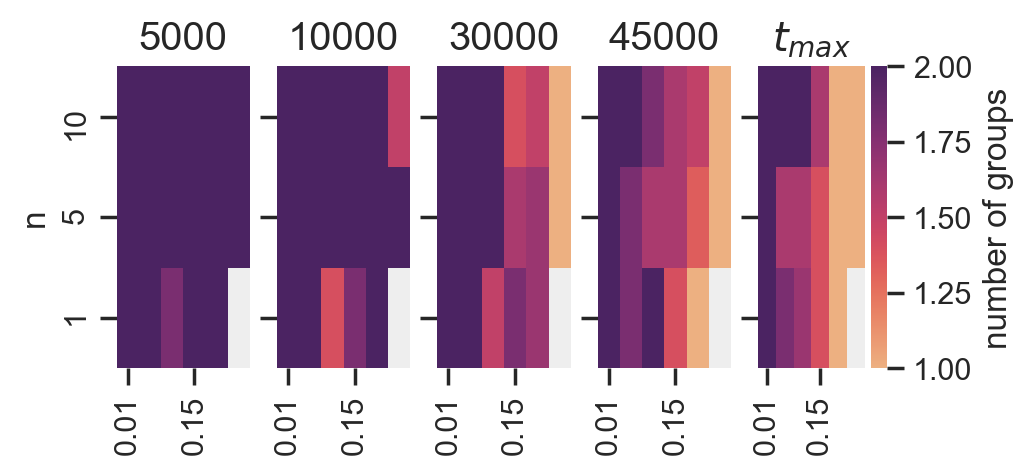

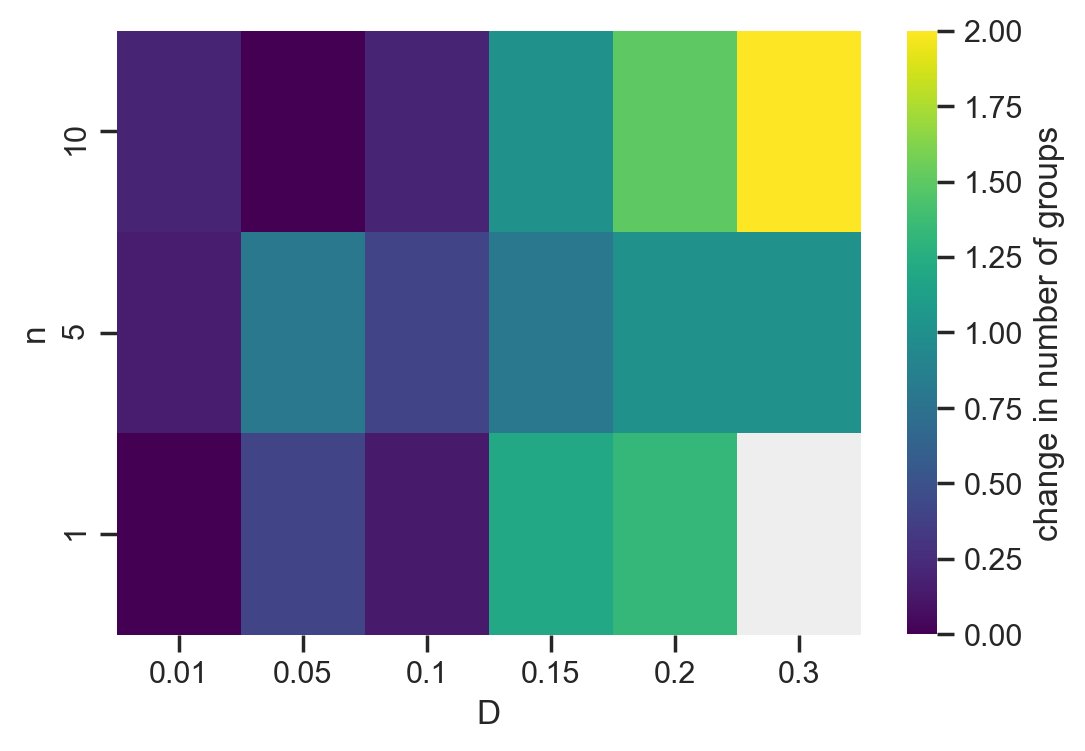

In [ ]:
vis_t_points = t_points[:2] + [t_points[len(t_points)//2]]+ t_points[-2:]
fig, axes = plt.subplots(ncols=len(vis_t_points), sharex=True, sharey=True, figsize=(5, 2))
vmin = max(1, df_avg_peaks["num_peaks"].min())
vmax = min(2, df_avg_peaks["num_peaks"].max())
for t, ax in zip(vis_t_points, axes):
    df_wide = (
        df_avg_peaks[df_avg_peaks["time"] == t]
        .rename(columns=COL_MAPPING)
        .pivot("n", "D", COL_MAPPING["num_peaks"])
    )
    df_wide.columns = df_wide.columns.astype(float)
    df_wide.index = df_wide.index.astype(int)
    df_wide = df_wide.sort_index(axis=1).sort_index(axis=0)
    df_wide.columns = [f"{x:.2f}" for x in df_wide.columns]

    sns.heatmap(
        df_wide.iloc[::-1],
        vmin=vmin,
        vmax=vmax,
        mask=df_wide.iloc[::-1].isna(),
        cmap="flare",
        ax=ax,
        cbar=ax == axes[-1],
        cbar_kws={"label": "number of groups"},
        # annot=True,
        # fmt=".1f",
    )
    ax.set_facecolor('#eeeeee') # missing values
    if ax != axes[0]:
        ax.set_ylabel("")
    if ax==axes[-1]:
        ax.set_title("$t_{max}$", fontsize="large")

    else:
        ax.set_title(f"{t}", fontsize="large")


df_peak_wide = df_peak_decrease.rename(columns=COL_MAPPING).pivot(
    "n", "D", values=COL_MAPPING["peak_decrease"]
)
df_peak_wide.columns = df_peak_wide.columns.astype(float)
df_peak_wide.index = df_peak_wide.index.astype(int)
df_peak_wide = df_peak_wide.sort_index(axis=1).sort_index(axis=0)
vals = df_peak_wide.iloc[::-1].abs()

fig, ax = plt.subplots()       
g = sns.heatmap(vals, mask=vals.isna(), cmap="viridis", cbar_kws={"label": "change in number of groups"}, ax=ax)
g.set_facecolor('#eeeeee') # missing values
